# Insurance cost prediction using linear regression


In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
!pip install numpy matplotlib pandas torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install jovian --upgrade -q
# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
project_name='02-assignment-insurance-linear-regression' # 

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: .\insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string 


In [6]:
your_name = "Rashee_Agarwal" # 

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
457,57,female,29.58015,0,no,northwest,13616.891308
1050,44,female,35.84635,1,no,northwest,9226.605767
56,58,female,30.87025,2,no,northeast,15648.474062
311,19,female,23.95900,0,no,southwest,1997.982400
1288,20,male,38.21800,2,yes,southwest,44096.250900


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [9]:
num_rows = len(dataframe.index)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [10]:
num_cols = len(dataframe.columns)
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [11]:
input_cols = list(dataframe.columns)
print(input_cols)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [12]:
categorical_cols = list(dataframe.select_dtypes(["object"]).columns)
print(categorical_cols)

['sex', 'smoker', 'region']


**Q: What are the column titles of output/target variable(s)?**

In [13]:
output_cols = ["charges"]
print(output_cols)

['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

count     1271.000000
mean     15089.132315
std      13674.749853
min       1290.154985
25%       5461.420667
50%      10700.407185
75%      18901.048819
max      73335.992212
Name: charges, dtype: float64


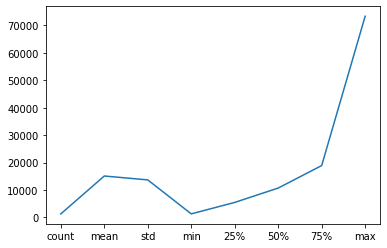

In [14]:
options = dataframe["charges"].describe()
print(options)
plt.plot(options)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [15]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [16]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[5.70000000e+01, 0.00000000e+00, 2.95801500e+01, ...,
         0.00000000e+00, 1.00000000e+00, 1.36168913e+04],
        [4.40000000e+01, 0.00000000e+00, 3.58463500e+01, ...,
         0.00000000e+00, 1.00000000e+00, 9.22660577e+03],
        [5.80000000e+01, 0.00000000e+00, 3.08702500e+01, ...,
         0.00000000e+00, 0.00000000e+00, 1.56484741e+04],
        ...,
        [5.90000000e+01, 0.00000000e+00, 3.37560000e+01, ...,
         0.00000000e+00, 3.00000000e+00, 4.24471992e+04],
        [4.10000000e+01, 1.00000000e+00, 2.79360000e+01, ...,
         0.00000000e+00, 3.00000000e+00, 7.22457025e+03],
        [3.60000000e+01, 0.00000000e+00, 2.91194000e+01, ...,
         0.00000000e+00, 1.00000000e+00, 6.06300217e+03]]),
 array([[13616.8913075],
        [ 9226.6057675],
        [15648.4740625],
        ...,
        [42447.1992345],
        [ 7224.57025  ],
        [ 6063.00217  ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [17]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [18]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [19]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [20]:
val_percent = 0.2 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [21]:
batch_size = 500

In [22]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [23]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[5.7000e+01, 1.0000e+00, 4.0866e+01,  ..., 1.0000e+00, 2.0000e+00,
         5.5977e+04],
        [4.0000e+01, 0.0000e+00, 2.4696e+01,  ..., 0.0000e+00, 0.0000e+00,
         8.1388e+03],
        [5.7000e+01, 1.0000e+00, 3.0594e+01,  ..., 0.0000e+00, 1.0000e+00,
         1.3056e+04],
        ...,
        [6.0000e+01, 1.0000e+00, 3.2117e+01,  ..., 0.0000e+00, 2.0000e+00,
         1.6008e+04],
        [2.0000e+01, 0.0000e+00, 2.6035e+01,  ..., 1.0000e+00, 2.0000e+00,
         1.9648e+04],
        [2.4000e+01, 0.0000e+00, 2.3498e+01,  ..., 0.0000e+00, 1.0000e+00,
         3.2692e+03]])
targets: tensor([[55976.8438],
        [ 8138.7676],
        [13056.2119],
        [ 7260.8228],
        [ 4593.3047],
        [ 9343.0693],
        [13943.7412],
        [ 5754.4312],
        [ 9232.1631],
        [ 1312.6619],
        [28198.3027],
        [ 1874.3085],
        [ 6991.6221],
        [15835.6123],
        [ 9594.3447],
        [ 7798.5571],
        [ 4014.1313],
        [1262

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [24]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [76]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)                 # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out =self.linear(xb)                         # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out,targets)                          #mse_loss not used because it leads to huge val_loss
        return {'val_loss': loss.detach()}                     #and smooth_l1_loss leads to huge variation in val_loss
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [77]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [78]:
list(model.parameters())

[Parameter containing:
 tensor([[0.0535, 0.0266, 0.2433, 0.2932, 0.2046, 0.0245, 0.2818]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2711], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [79]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [80]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 9596.75}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [96]:
epochs = 1000
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 451757.2188
Epoch [40], val_loss: 692461.8750
Epoch [60], val_loss: 35533.3164
Epoch [80], val_loss: 934690.6250
Epoch [100], val_loss: 2507391.5000
Epoch [120], val_loss: 525147.4375
Epoch [140], val_loss: 1530816.5000
Epoch [160], val_loss: 186409.0781
Epoch [180], val_loss: 1516855.3750
Epoch [200], val_loss: 1118339.3750
Epoch [220], val_loss: 121680.2578
Epoch [240], val_loss: 653580.0625
Epoch [260], val_loss: 298259.3750
Epoch [280], val_loss: 1692193.2500
Epoch [300], val_loss: 1920183.7500
Epoch [320], val_loss: 412176.0000
Epoch [340], val_loss: 1979990.1250
Epoch [360], val_loss: 969090.0000
Epoch [380], val_loss: 1805816.5000
Epoch [400], val_loss: 92688.6562
Epoch [420], val_loss: 1297924.6250
Epoch [440], val_loss: 760394.1875
Epoch [460], val_loss: 1098583.2500
Epoch [480], val_loss: 1075068.3750
Epoch [500], val_loss: 1688735.7500
Epoch [520], val_loss: 1112842.8750
Epoch [540], val_loss: 791006.2500
Epoch [560], val_loss: 688644.4375
Epoch [580], 

In [82]:
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 161496.8750
Epoch [40], val_loss: 122564.4531
Epoch [60], val_loss: 123330.9141
Epoch [80], val_loss: 137922.7969
Epoch [100], val_loss: 68646.1406
Epoch [120], val_loss: 80896.6797
Epoch [140], val_loss: 188141.6250
Epoch [160], val_loss: 60714.2422
Epoch [180], val_loss: 75189.4453
Epoch [200], val_loss: 159332.2031
Epoch [220], val_loss: 169829.3281
Epoch [240], val_loss: 34208.0820
Epoch [260], val_loss: 172309.7969
Epoch [280], val_loss: 67505.6641
Epoch [300], val_loss: 125681.9531
Epoch [320], val_loss: 99211.3047
Epoch [340], val_loss: 104870.2812
Epoch [360], val_loss: 201917.2656
Epoch [380], val_loss: 80197.1250
Epoch [400], val_loss: 150202.0938
Epoch [420], val_loss: 121857.6406
Epoch [440], val_loss: 128832.2109
Epoch [460], val_loss: 189564.4219
Epoch [480], val_loss: 201154.2969
Epoch [500], val_loss: 102169.7891
Epoch [520], val_loss: 76907.0781
Epoch [540], val_loss: 70679.4062
Epoch [560], val_loss: 65434.7461
Epoch [580], val_loss: 35048.2695
E

In [83]:
epochs = 1000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5067.7017
Epoch [40], val_loss: 13245.2783
Epoch [60], val_loss: 5588.4517
Epoch [80], val_loss: 14091.1797
Epoch [100], val_loss: 6693.6255
Epoch [120], val_loss: 4769.0259
Epoch [140], val_loss: 15696.7158
Epoch [160], val_loss: 6947.6694
Epoch [180], val_loss: 17603.9688
Epoch [200], val_loss: 8233.2393
Epoch [220], val_loss: 14290.6289
Epoch [240], val_loss: 165.2945
Epoch [260], val_loss: 4801.3652
Epoch [280], val_loss: 11671.8242
Epoch [300], val_loss: 9506.6104
Epoch [320], val_loss: 4966.2500
Epoch [340], val_loss: 17765.6504
Epoch [360], val_loss: 2477.3176
Epoch [380], val_loss: 9233.9551
Epoch [400], val_loss: 2965.7266
Epoch [420], val_loss: 5332.9849
Epoch [440], val_loss: 12959.3799
Epoch [460], val_loss: 12459.6289
Epoch [480], val_loss: 18208.2285
Epoch [500], val_loss: 2851.0957
Epoch [520], val_loss: 21576.6973
Epoch [540], val_loss: 15494.9746
Epoch [560], val_loss: 2540.0122
Epoch [580], val_loss: 9356.7969
Epoch [600], val_loss: 2631.7349
Epo

In [84]:
epochs = 1000
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1016.0431
Epoch [40], val_loss: 1483.2618
Epoch [60], val_loss: 1358.5853
Epoch [80], val_loss: 1523.5822
Epoch [100], val_loss: 486.0750
Epoch [120], val_loss: 528.8635
Epoch [140], val_loss: 636.7278
Epoch [160], val_loss: 410.8029
Epoch [180], val_loss: 1365.8571
Epoch [200], val_loss: 1899.4358
Epoch [220], val_loss: 75.2975
Epoch [240], val_loss: 2133.0437
Epoch [260], val_loss: 527.7023
Epoch [280], val_loss: 1282.5536
Epoch [300], val_loss: 2186.2229
Epoch [320], val_loss: 970.5801
Epoch [340], val_loss: 646.9608
Epoch [360], val_loss: 1276.4679
Epoch [380], val_loss: 1526.0782
Epoch [400], val_loss: 1055.2546
Epoch [420], val_loss: 608.8531
Epoch [440], val_loss: 2701.4539
Epoch [460], val_loss: 768.1093
Epoch [480], val_loss: 763.8523
Epoch [500], val_loss: 2083.6360
Epoch [520], val_loss: 1324.4589
Epoch [540], val_loss: 1680.8246
Epoch [560], val_loss: 86.5140
Epoch [580], val_loss: 1821.8994
Epoch [600], val_loss: 1110.0668
Epoch [620], val_loss: 1503.

In [85]:
epochs = 1000
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 159.4716
Epoch [40], val_loss: 143.2305
Epoch [60], val_loss: 91.6586
Epoch [80], val_loss: 74.6564
Epoch [100], val_loss: 72.9304
Epoch [120], val_loss: 81.8467
Epoch [140], val_loss: 151.6670
Epoch [160], val_loss: 75.2665
Epoch [180], val_loss: 125.7093
Epoch [200], val_loss: 73.2671
Epoch [220], val_loss: 74.5073
Epoch [240], val_loss: 75.1490
Epoch [260], val_loss: 220.6978
Epoch [280], val_loss: 131.8979
Epoch [300], val_loss: 85.5043
Epoch [320], val_loss: 92.8311
Epoch [340], val_loss: 202.8619
Epoch [360], val_loss: 142.2441
Epoch [380], val_loss: 100.9710
Epoch [400], val_loss: 88.8676
Epoch [420], val_loss: 179.2268
Epoch [440], val_loss: 93.6567
Epoch [460], val_loss: 75.2029
Epoch [480], val_loss: 76.7317
Epoch [500], val_loss: 73.8244
Epoch [520], val_loss: 100.0917
Epoch [540], val_loss: 76.1879
Epoch [560], val_loss: 195.2149
Epoch [580], val_loss: 73.8404
Epoch [600], val_loss: 74.0240
Epoch [620], val_loss: 74.6298
Epoch [640], val_loss: 149.2488

**Q: What is the final validation loss of your model?**

In [86]:
val_loss = 140.9371         #min val_loss attained obtained from above

Let's log the final validation loss to Jovian and commit the notebook

In [87]:
#jovian.log_metrics(val_loss=val_loss )

In [88]:
#*jovian.commit(project=project_name, environment=None)

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [89]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)             # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [90]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([3.1000e+01, 1.0000e+00, 2.5157e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        4.8759e+03])
Target: tensor([4875.8765])
Prediction: tensor([4865.7705])


In [91]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([  19.0000,    0.0000,   19.9820,    0.0000,    0.0000,    3.0000,
        1991.4286])
Target: tensor([1991.4286])
Prediction: tensor([1959.1333])


In [92]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([5.3000e+01, 1.0000e+00, 2.3590e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.1343e+04])
Target: tensor([11342.9922])
Prediction: tensor([11411.9717])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039